# MLP Autoencoder

In [1]:
import os
import tensorflow as tf
import numpy as np
from scipy import misc
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow.contrib.slim as slim
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)  ## just for ignore DeprcationWarning message
print("Current version [%s]" %(tf.__version__))
print("Packages Loaded")

Current version [1.3.1]
Packages Loaded


### Configurations

In [2]:
# Dataset Configurations
tf.app.flags.DEFINE_integer('img_size', 32, """Image size of MAP dataset""")
tf.app.flags.DEFINE_string('train_dir', './../../Rent3D-modified/crop_imgs32/train', """Dir contains train data""")
tf.app.flags.DEFINE_string('test_dir', './../../Rent3D-modified/crop_imgs32/test', """Dir contains test data""")

# Network Configurations
tf.app.flags.DEFINE_integer('batch_size', 64, """Number of images to process in a batch""")
# tf.app.flags.DEFINE_float('l1_ratio', 0.5, """Ratio of level1""")
# tf.app.flags.DEFINE_float('l2_ratio', 0.5, """Ratio of level2""")

# Optimization Configurations
tf.app.flags.DEFINE_float('lr', 0.001, """Learning rate""")

# Training Configurations
tf.app.flags.DEFINE_integer('training_epochs', 100, """Number of epochs to run""")
tf.app.flags.DEFINE_integer('display_step', 10, """Number of iterations to display training output""")
tf.app.flags.DEFINE_integer('save_step', 10, """Number of interations to save checkpoint""")
tf.app.flags.DEFINE_integer('save_max', 5, """Number of checkpoints to remain""")


# Save Configurations
tf.app.flags.DEFINE_string('nets', './nets', """Directory where to write the checkpoints""")
tf.app.flags.DEFINE_string('outputs', './outputs', """Directory where to save the output images""")
tf.app.flags.DEFINE_string('tboard', './tensorboard', """Directory where to save the tensorboard logs""")


FLAGS = tf.app.flags.FLAGS
print("FLAGS READY")

FLAGS READY


### GPU control

In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True

### Load Data

In [4]:
train_dir = FLAGS.train_dir
train_img = os.listdir(train_dir)
train_img.sort()

test_dir = FLAGS.test_dir
test_img = os.listdir(test_dir)
test_img.sort()

def gray_mask(_img):
    mask = (_img!=128).astype(float)
    return mask
    
def norm_read(_dir,_id):
    _img = np.reshape(misc.imread(_dir+'/'+_id), [-1])
    mask = gray_mask(_img)
    return _img.astype(float)/255., mask

def certain_region(_img, _mask):
    certain = np.multiply(_img, _mask)
    return certain

print("Data loaded")

Data loaded


### Generating observation mask

In [5]:
def observe_mask():
    mask = np.zeros([FLAGS.img_size, FLAGS.img_size])
    # threshold of the size of masks
    uthd = FLAGS.img_size    
    lthd = 0     
    # mask size should be beween 48x48, 16x16
    while(uthd>48 or lthd<16):
        ver1 = np.random.random_integers(0, FLAGS.img_size-1, size= 2)   # vertex1
        ver2 = np.random.random_integers(0, FLAGS.img_size-1, size= 2)    # vertex2
        uthd = np.maximum(np.abs(ver1[0]-ver2[0]), np.abs(ver1[1]-ver2[1]))    # upperbound
        lthd = np.minimum(np.abs(ver1[0]-ver2[0]), np.abs(ver1[1]-ver2[1]))    # lowerbound
    xmin = np.minimum(ver1[0], ver2[0])    # left x value
    xmax = np.maximum(ver1[0], ver2[0])    # right x value
    ymin = np.minimum(ver1[1], ver2[1])    # top y value
    ymax = np.maximum(ver1[1], ver2[1])    # bottom y value
    observe = np.ones([xmax-xmin+1, ymax-ymin+1])    # observation area
    mask[xmin:xmax+1, ymin:ymax+1] = observe    # observation with location
#     mask = np.reshape(mask, [-1])
    return mask

def observe_batch(batch_num):
    # make random noise batch
    mask_batch = np.zeros([batch_num, FLAGS.img_size,FLAGS.img_size])
    for i in range(batch_num):
        mask_batch[i] = observe_mask()
    return mask_batch

def observe(full, obs):
    return np.multiply(full, obs)

### Graph setup

In [6]:
# Network Topology
n_input = FLAGS.img_size*FLAGS.img_size
n_enc1 = 512
n_enc2 = 256
n_enc3 = 128
n_dec1 = 256
n_dec2 = 512
n_out = FLAGS.img_size*FLAGS.img_size

# Inputs and Outputs
_map = tf.placeholder("float", [None, n_input])
_gmask = tf.placeholder("float", [None, n_input])

# Nework Parameters
def mlp_ae(_input):
    init = tf.random_normal_initializer(stddev=0.1)
    enc1 = slim.fully_connected(_input, n_enc1, activation_fn=tf.nn.sigmoid, weights_initializer=init, scope='enc1')
    enc2 = slim.fully_connected(_input, n_enc2, activation_fn=tf.nn.sigmoid, weights_initializer=init, scope='enc2')
    enc3 = slim.fully_connected(_input, n_enc3, activation_fn=tf.nn.sigmoid, weights_initializer=init, scope='enc3')
    dec1 = slim.fully_connected(_input, n_dec1, activation_fn=tf.nn.sigmoid, weights_initializer=init, scope='dec1')
    dec2 = slim.fully_connected(_input, n_dec2, activation_fn=tf.nn.sigmoid, weights_initializer=init, scope='dec2')
    out = slim.fully_connected(_input, n_out, activation_fn=tf.nn.sigmoid, weights_initializer=init, scope='out')
    return out

gen = mlp_ae(_map)
# Loss & Optimizer
with tf.name_scope("loss") as scope:
#     loss = tf.reduce_sum(tf.abs(gen-y))
    loss = tf.reduce_mean(tf.nn.l2_loss(certain_region(gen-_map, _gmask)))
#     loss = tf.reduce_mean(tf.nn.l2_loss(gen-_map))
    _train_loss = tf.summary.scalar("train_loss", loss)
    _test_loss = tf.summary.scalar("test_loss", loss)
    
optm = tf.train.AdamOptimizer(learning_rate=FLAGS.lr).minimize(loss)

print("Network Ready")

Network Ready


### Initialize

In [7]:
merged = tf.summary.merge_all()
tensorboard_path = FLAGS.tboard
if not os.path.exists(tensorboard_path):
    os.makedirs(tensorboard_path)
writer = tf.summary.FileWriter(tensorboard_path)
init = tf.global_variables_initializer()

print("Initialize Ready")

Initialize Ready


### Data saving

In [8]:
outputdir = FLAGS.outputs
if not os.path.exists(outputdir+'/train'):
    os.makedirs(outputdir+'/train')

if not os.path.exists(outputdir+'/test'):
    os.makedirs(outputdir+'/test')
    
savedir = FLAGS.nets
if not os.path.exists(savedir):
    os.makedirs(savedir)
    
saver = tf.train.Saver(max_to_keep=FLAGS.save_max)
print("Saver ready")

Saver ready


### Run

In [9]:
#%%debug
# Parameters
training_epochs = FLAGS.training_epochs
batch_size = FLAGS.batch_size
display_step = FLAGS.display_step
# Plot
n_plot = 5    # plot 5 images
train_disp_idx = np.copy(np.random.choice(train_img, size=n_plot, replace=False))    # fixed during train time
test_disp_idx = np.copy(np.random.choice(test_img, size=n_plot, replace=False))
with tf.device('/cpu:0'):
    train_disp_img = []
    train_disp_img_gm = []    # gray mask
    test_disp_img = []
    test_disp_img_gm = []
    for img in range(n_plot):
        train_disp_img.append(norm_read(train_dir,train_disp_idx[img])[0])
        train_disp_img_gm.append(norm_read(train_dir,train_disp_idx[img])[1])
        test_disp_img.append(norm_read(test_dir,test_disp_idx[img])[0])
        test_disp_img_gm.append(norm_read(test_dir,test_disp_idx[img])[1])
    train_disp_crt = certain_region(train_disp_img, train_disp_img_gm)
    test_disp_crt = certain_region(test_disp_img, test_disp_img_gm)

# Initialize
sess = tf.Session(config=config)
sess.run(init)

# Optimize
for epoch in range(training_epochs):
    total_cost = 0.
    n_total_batch = int(np.size(train_img)/batch_size)
    rand_train_idx = np.random.choice(train_img, size=batch_size, replace=False)    # For display losses
    rand_test_idx = np.random.choice(test_img, size=batch_size, replace=False)    # For display losses
    
    np.random.seed(epoch)
    np.random.shuffle(train_img)
        
    # Iteration
    for batch in range(n_total_batch):
        with tf.device('/cpu:0'):
            batch_img = []
            batch_img_gm = []
            for img in range(batch_size):
                batch_img.append(norm_read(train_dir,train_img[batch*batch_size + img])[0])
                batch_img_gm.append(norm_read(train_dir,train_img[batch*batch_size + img])[1])
            feeds = {_map: batch_img, _gmask:batch_img_gm}
        sess.run(optm, feed_dict=feeds)
    
    with tf.device('/cpu:0'):
        train_batch_img = []
        train_batch_img_gm = []
        test_batch_img = []
        test_batch_img_gm = []
        for img in range(batch_size):
            train_batch_img.append(norm_read(train_dir,rand_train_idx[img])[0])
            train_batch_img_gm.append(norm_read(train_dir,rand_train_idx[img])[1])
            test_batch_img.append(norm_read(test_dir,rand_test_idx[img])[0])
            test_batch_img_gm.append(norm_read(test_dir,rand_test_idx[img])[1])
        train_feeds = {_map: train_batch_img, _gmask:train_batch_img_gm}
        test_feeds = {_map: test_batch_img, _gmask:test_batch_img_gm}
    train_loss, tb_train_loss = sess.run([loss,_train_loss], feed_dict=train_feeds)
    test_loss, tb_test_loss = sess.run([loss,_test_loss], feed_dict=test_feeds)
    
    writer.add_summary(tb_train_loss, epoch)
    writer.add_summary(tb_test_loss, epoch)
    print("Epoch : %03d/%03d  Train_loss : %.7f  Test_loss : %.7f" 
          % (epoch+1, training_epochs, train_loss, test_loss))   
        
    # Display
    if (epoch+1) % display_step == 0:
        # generated images
        train_gen_full = sess.run(gen, feed_dict={_map:train_disp_img})  
        test_gen_full = sess.run(gen, feed_dict={_map:test_disp_img})
        
        train_gen_full_crt = certain_region(train_gen_full, train_disp_img_gm)
        test_gen_full_crt = certain_region(test_gen_full, test_disp_img_gm)
        
        # plotting results from training data
        fig, axes = plt.subplots(nrows=4, ncols=n_plot, figsize=(10,10))   # displaying 4*n_plot images
        plt.setp(axes, xticks=np.arange(0,31,8), yticks=np.arange(0,31,8)) 
        for j in range(n_plot):
            train_disp_full_map = np.reshape(train_disp_img[j], [32,32])    # 28x28
            axes[0, j].imshow(train_disp_full_map, cmap='gray')   
            axes[0, j].set(ylabel='gt_map')
            axes[0, j].label_outer()
            
            train_crt = np.reshape(train_disp_crt[j], [32,32])    # 28x28
            axes[1, j].imshow(train_crt, cmap='gray')   
            axes[1, j].set(ylabel='certain')
            axes[1, j].label_outer()
            
            train_disp_gen_full = np.reshape(train_gen_full[j], [32,32])    # 28x28
            axes[2, j].imshow(train_disp_gen_full, cmap='gray')   
            axes[2, j].set(ylabel='full_map')
            axes[2, j].label_outer()
            
            train_disp_gen_full_crt = np.reshape(train_gen_full_crt[j], [32,32])    # 28x28
            axes[3, j].imshow(train_disp_gen_full_crt, cmap='gray')   
            axes[3, j].set(ylabel='full_map_crt')
            axes[3, j].label_outer()
                    
        plt.savefig(outputdir+'/train/epoch %03d' %(epoch+1))    
        plt.close(fig)
        
        # plotting results from testing data
        fig, axes = plt.subplots(nrows=4, ncols=n_plot, figsize=(10,10))   # displaying 4*n_plot images
        plt.setp(axes, xticks=np.arange(0,31,8), yticks=np.arange(0,31,8)) 
        for j in range(n_plot):
            test_disp_full_map = np.reshape(test_disp_img[j], [32,32])    # 28x28
            axes[0, j].imshow(test_disp_full_map, cmap='gray')   
            axes[0, j].set(ylabel='gt_map')
            axes[0, j].label_outer()
            
            test_crt = np.reshape(test_disp_crt[j], [32,32])    # 28x28
            axes[1, j].imshow(test_crt, cmap='gray')   
            axes[1, j].set(ylabel='certain')
            axes[1, j].label_outer()
            
            test_disp_gen_full = np.reshape(test_gen_full[j], [32,32])    # 28x28
            axes[2, j].imshow(test_disp_gen_full, cmap='gray')   
            axes[2, j].set(ylabel='full_map')
            axes[2, j].label_outer()        
            
            test_disp_gen_full_crt = np.reshape(test_gen_full_crt[j], [32,32])    # 28x28
            axes[3, j].imshow(test_disp_gen_full_crt, cmap='gray')   
            axes[3, j].set(ylabel='full_map_crt')
            axes[3, j].label_outer()
                                
        plt.savefig(outputdir+'/test/epoch %03d' %(epoch+1))    
        plt.close(fig)
        
        # Save
        if (epoch+1) % FLAGS.save_step ==0:
            savename = savedir+"/net-"+str(epoch+1)+".ckpt"
            saver.save(sess, savename)
            print("[%s] SAVED" % (savename))

print("Optimization Finished")

Epoch : 001/100  Train_loss : 2585.1091309  Test_loss : 3216.8586426
Epoch : 002/100  Train_loss : 2226.6215820  Test_loss : 2412.1076660
Epoch : 003/100  Train_loss : 1447.8105469  Test_loss : 1852.8392334
Epoch : 004/100  Train_loss : 1363.7631836  Test_loss : 1559.2247314
Epoch : 005/100  Train_loss : 1099.1065674  Test_loss : 1223.4304199
Epoch : 006/100  Train_loss : 816.4476318  Test_loss : 1145.7045898
Epoch : 007/100  Train_loss : 683.3843994  Test_loss : 748.0148926
Epoch : 008/100  Train_loss : 712.1752930  Test_loss : 793.9008789
Epoch : 009/100  Train_loss : 552.5515747  Test_loss : 645.6970215
Epoch : 010/100  Train_loss : 517.6941528  Test_loss : 622.3126831
[./nets/net-10.ckpt] SAVED
Epoch : 011/100  Train_loss : 451.9730530  Test_loss : 510.2887268
Epoch : 012/100  Train_loss : 345.3495483  Test_loss : 494.3038025
Epoch : 013/100  Train_loss : 341.8293762  Test_loss : 499.3101501
Epoch : 014/100  Train_loss : 314.2414551  Test_loss : 431.1618042
Epoch : 015/100  Train_l

### Restore

In [10]:
do_restore = 1
if do_restore == 1:
    sess = tf.Session()
    epoch = 100
    savename = savedir+"/net-"+str(epoch)+".ckpt"
    saver.restore(sess, savename)
    print ("NETWORK RESTORED")
else:
    print ("DO NOTHING")

INFO:tensorflow:Restoring parameters from ./nets/net-100.ckpt
NETWORK RESTORED


### Test

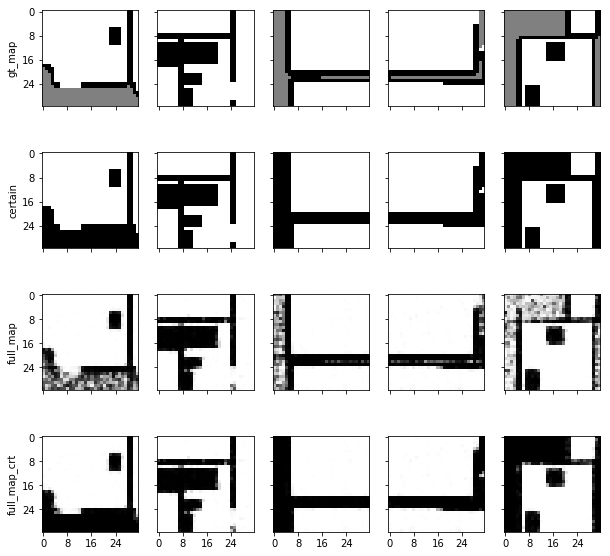

In [12]:
n_plot = 5    # plot 5 images
test_disp_idx = np.copy(np.random.choice(test_img, size=n_plot, replace=False))
with tf.device('/cpu:0'):
    test_disp_img = []
    test_disp_img_gm = []
    for img in range(n_plot):
        test_disp_img.append(norm_read(test_dir,test_disp_idx[img])[0])
        test_disp_img_gm.append(norm_read(test_dir,test_disp_idx[img])[1])
    test_disp_crt = certain_region(test_disp_img, test_disp_img_gm)
    
test_gen_full = sess.run(gen, feed_dict={_map:test_disp_img})
test_gen_full_crt = certain_region(test_gen_full, test_disp_img_gm)

# plotting results from testing data
fig, axes = plt.subplots(nrows=4, ncols=n_plot, figsize=(10,10))   # displaying 4*n_plot images
plt.setp(axes, xticks=np.arange(0,31,8), yticks=np.arange(0,31,8)) 
for j in range(n_plot):
    test_disp_full_map = np.reshape(test_disp_img[j], [32,32])    # 28x28
    axes[0, j].imshow(test_disp_full_map, cmap='gray')   
    axes[0, j].set(ylabel='gt_map')
    axes[0, j].label_outer()

    test_crt = np.reshape(test_disp_crt[j], [32,32])    # 28x28
    axes[1, j].imshow(test_crt, cmap='gray')   
    axes[1, j].set(ylabel='certain')
    axes[1, j].label_outer()

    test_disp_gen_full = np.reshape(test_gen_full[j], [32,32])    # 28x28
    axes[2, j].imshow(test_disp_gen_full, cmap='gray')   
    axes[2, j].set(ylabel='full_map')
    axes[2, j].label_outer()        

    test_disp_gen_full_crt = np.reshape(test_gen_full_crt[j], [32,32])    # 28x28
    axes[3, j].imshow(test_disp_gen_full_crt, cmap='gray')   
    axes[3, j].set(ylabel='full_map_crt')
    axes[3, j].label_outer()
